In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from IPython import display

import seaborn as sns
sns.set( palette="pastel")

In [0]:
arr = np.array([
                [[1, 3, 2], 
                 [2, 5, 4], 
                 [3, 8, 9]],
                
                [
                 [1, 3, 2],
                 [3, 8, 9],
                 [2, 5, 4]]
                ]
              )

In [0]:
arr.shape

(2, 3, 3)

In [0]:
tens = torch.tensor(arr)
tens.shape

torch.Size([2, 3, 3])

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#### 1. Загрузка и предобработка данных

In [0]:
PATH_DEVICE = '/content/gdrive/My Drive/Colab Notebooks/course work/data/device_1'
PATH_BENIGN_TRAFFIC = 'benign_traffic.csv'

PATH_GAFGYT_UDP = 'gafgyt_attacks/udp.csv'
PATH_GAFGYT_TCP = 'gafgyt_attacks/tcp.csv'
PATH_GAFGYT_SCAN = 'gafgyt_attacks/scan.csv'
PATH_GAFGYT_JUNK = 'gafgyt_attacks/junk.csv'
PATH_GAFGYT_COMBO = 'gafgyt_attacks/combo.csv'

PATH_MIRAI_UDPPLAIN = 'mirai_attacks/udpplain.csv'
PATH_MIRAI_UDP = 'mirai_attacks/udp.csv'
PATH_MIRAI_SYN = 'mirai_attacks/syn.csv'
PATH_MIRAI_SCAN = 'mirai_attacks/scan.csv'
PATH_MIRAI_ACK = 'mirai_attacks/ack.csv'

In [0]:
df_benign = pd.read_csv(os.path.join(PATH_DEVICE, PATH_BENIGN_TRAFFIC))

df_gafgyt_udp = pd.read_csv(os.path.join(PATH_DEVICE, PATH_GAFGYT_UDP))
df_gafgyt_tcp = pd.read_csv(os.path.join(PATH_DEVICE, PATH_GAFGYT_TCP))
df_gafgyt_scan = pd.read_csv(os.path.join(PATH_DEVICE, PATH_GAFGYT_SCAN))
df_gafgyt_junk = pd.read_csv(os.path.join(PATH_DEVICE, PATH_GAFGYT_JUNK))
df_gafgyt_combo = pd.read_csv(os.path.join(PATH_DEVICE, PATH_GAFGYT_COMBO))

df_mirai_udpplain = pd.read_csv(os.path.join(PATH_DEVICE, PATH_MIRAI_UDPPLAIN))
df_mirai_udp = pd.read_csv(os.path.join(PATH_DEVICE, PATH_MIRAI_UDP))
df_mirai_syn = pd.read_csv(os.path.join(PATH_DEVICE, PATH_MIRAI_SYN))
df_mirai_scan = pd.read_csv(os.path.join(PATH_DEVICE, PATH_MIRAI_SCAN))
df_mirai_ack = pd.read_csv(os.path.join(PATH_DEVICE, PATH_MIRAI_ACK))

In [0]:
datasets = {'benign': df_benign, 'gafgyt_udp': df_gafgyt_udp, 'gafgyt_tcp': df_gafgyt_tcp,
           'gafgyt_scan': df_gafgyt_scan, 'gafgyt_junk': df_gafgyt_junk, 
           'gafgyt_combo': df_gafgyt_combo, 'mirai_udpplain': df_mirai_udpplain,
           'mirai_udp': df_mirai_udp, 'mirai_syn': df_mirai_syn,
           'mirai_scan': df_mirai_scan, 'mirai_ack': df_mirai_ack
           }

for name, df in datasets.items():
    print(f'Dataset {name} length: {len(df)}')

Dataset benign length: 46585
Dataset gafgyt_udp length: 103720
Dataset gafgyt_tcp length: 88816
Dataset gafgyt_scan length: 27825
Dataset gafgyt_junk length: 28579
Dataset gafgyt_combo length: 54283
Dataset mirai_udpplain length: 78244
Dataset mirai_udp length: 151879
Dataset mirai_syn length: 125715
Dataset mirai_scan length: 45930
Dataset mirai_ack length: 111480


In [0]:
train_df, val_df = train_test_split(df_benign.values, shuffle=True, test_size=0.2)
val_df, test_df = train_test_split(val_df, shuffle=True, test_size=0.5)

assert len(val_df) + len(test_df) + len(train_df) == len(df_benign)

In [0]:
# normalize the data
normalizer = StandardScaler()
train_df = normalizer.fit_transform(train_df)
val_df = normalizer.transform(val_df)
test_df = normalizer.transform(test_df)

### 2. Эксперименты



#### 2.1 Deep autoencoder

Вспомогательные классы и функции

In [0]:
class TrafficDataset(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        
        #X = self.df.iloc[idx, :].values
        X = self.df[idx]
        X = torch.tensor(X, dtype=torch.float32)
            
        return X
    
    def __len__(self):
        return len(self.df)

In [0]:
class Logger(object):
    '''
    Instance of this class sums values of e.g. the loss function over
    different iterations in one epoch, compute the average value of loss for
    this epoch and save it to list.
    '''

    def __init__(self):

        self.last = 0.0
        self.average = 0.0
        self.sum = 0.0
        self.count = 0
        self.history = []

    def update(self, value):
        '''
        Update the state of the logger instance:
        - add value to the self.sum attribute
        - increment count of seen values
        - reestimate average value

        This method must be called after each iteration over a mini-batch.
        '''

        self.count += 1
        self.last = value
        self.sum += value
        self.average = self.sum / self.count

    def reset(self):
        '''
        Zero-out all attributes except self.history.

        This method must be called at the begining of each epoch. 
        '''

        self.last = 0.0
        self.average = 0.0
        self.sum = 0.0
        self.count = 0

    def save(self):
        '''
        Save the obtained average value to the list. 

        This method must be called at the end of each epoch. 
        '''

        self.history.append(self.average)

In [0]:
def save_checkpoint(state_dict, path='', improved=False):
    '''
    Saves checkpoint with state dictionary at the current epoch, and state
    dictionary of the best model. 

    ================================================================
    state_dict -- dict, dictionary containing states of model/optimizer etc.

    path -- str, path to directory where to save the checkpoint and/or the
            best model
    improved -- bool, flag used to save the current state to the separate 
                file when there was an improvement in validation accuracy
    ================================================================
    '''

    torch.save(state_dict, os.path.join(path, 'checkpoint.tar'))
    if improved:
        torch.save(state_dict, os.path.join(path, 'best_model.tar'))

In [0]:
def train_epoch(train_loader, model, device, optimizer, criterion, epoch, loss_logger,
          tensorboard=False, tbc_inst=None, verbose=None):
    '''
    Executes one epoch of model training. Computes forward pass and backward pass
    *num_batches* times.

    ================================================================
    train_loader -- torch.utils.data.DataLoader instance, generator  which provides
                    samples from the train dataset

    model -- torch.nn.Module instance, a model to train

    device -- torch.device, a device to train on

    optimizer -- instance of some class from torch.optim used to update parameters
                 of the model

    criterion -- instance of a loss function class from torch.nn.

    epoch -- int, number of the current epoch

    loss_logger -- Logger instance which is used to compute average value of the 
                   loss in one epoch and cache it

    tensorboard -- bool, whether to visualize learning curves in TensorBoard

    tbc_inst -- TensorBoardColab instance, used to transfer data from GoogleColab
                to TensorBoard local server

    verbose -- int, defines the number of epochs after which the learning stats
               will be printed
    ================================================================
    '''
  
    loss_logger.reset()

    model.train()

    for X in train_loader:
        X = X.to(device)

        optimizer.zero_grad()
        Y_pred = model.forward(X)
        loss = criterion(Y_pred, X)
        loss.backward()
        loss_logger.update(loss)

        optimizer.step()
            
    loss_logger.save()
    # plot training progress in tensorboard
    if tensorboard:
        tbc_inst.save_value('Learning curves', 'Training loss', epoch, 
                            loss_logger.average)
        tbc_inst.close()

    # print training progress
    if verbose:
        # print every 10th epoch
        if epoch % verbose == 0:
            print(f'Epoch: {epoch} | Train loss: {round(loss_logger.average.item(), 4)} | ',  end=' ')

In [0]:
def validate_epoch(val_loader, model, device, epoch, logger, tensorboard=False, 
             tbc_inst=None, verbose=None):
    '''
    Executes model validation. Computes forward pass *num_val_batches* times.

    ================================================================
    val_loader -- torch.utils.data.DataLoader instance, generator  which provides
                    samples from the validation dataset

    model -- torch.nn.Module instance, a model to evaluate

    device -- torch.device, a device to evaluate on

    epoch -- int, number of the current epoch

    logger -- Logger instance which is used to compute average value of the 
            loss in one epoch and cache it

    tensorboard -- bool, whether to visualize learning curves in TensorBoard

    tbc_inst -- TensorBoardColab instance, used to transfer data from GoogleColab
              to TensorBoard local server

    verbose -- int, defines the number of epochs after which the learning stats
             will be printed
    ================================================================
    '''
    logger.reset()
  
    model.eval()
  
    for X in val_loader:
        X = X.to(device)

        Y_pred = model.forward(X)
        loss = criterion(Y_pred, X).detach().cpu().numpy()
        logger.update(loss)
    
    logger.save()
   
    # plot training progress in tensorboard
    if tensorboard:
        tbc_inst.save_value('Learning curves', 'Validation loss', epoch, 
                            logger.average)
        tbc_inst.close()
    
    # print training progress
    if verbose:
        # print every 10th epoch
        if epoch % verbose == 0:
            print(f'Validation loss: {round(logger.average.item(), 4)} | Gradient: {torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)}')
      
    return logger.average

In [0]:
def calculate_threshold(model, X):
    Y_pred = model.forward(X)
    losses = torch.mean(torch.pow(X - Y_pred, 2), dim=1)
    
    assert losses.shape[0] == X.shape[0]
    
    model.threshold = torch.mean(losses) + torch.std(losses)

In [0]:
def predict(model, data, device):
    data = torch.tensor(data, dtype=torch.float32, device=device)
    out = model(data)
    losses = torch.mean(torch.pow(data - out, 2), dim=1)
    y_pred = (losses >= model.threshold).detach().cpu().numpy()
    
    return y_pred

In [0]:
def train(train_dataloader, val_dataloader, val_dataset, model, max_epoch, 
          optimizer, criterion, scheduler=None):
  
    try: 
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')

        best_val_loss = torch.tensor(np.inf)
        model.to(device)
        print(f'Model is on {device}')

        train_loss_logger = Logger()
        val_loss_logger = Logger()

        # start training process
        for epoch in range(1, max_epoch+1):
            display.clear_output(wait=True)
            # train a model for one epoch
            train_epoch(train_dataloader, model, device, optimizer, criterion, epoch, 
                train_loss_logger, verbose=1)

            # evaluate model on val set
            current_loss = validate_epoch(val_dataloader, model, device, epoch, logger=val_loss_logger,
                                  verbose=1)

            if scheduler:
                scheduler.step(current_loss)
            
            # update model's threshold on val dataset
            calculate_threshold(model, torch.tensor(val_dataset, dtype=torch.float32, device=device))
            
            # plot learning and accuracy curves vs epoch#
            fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi=100)

            axes.set_title('Learning curves')
            axes.set_ylabel('Loss')
            axes.set_xlabel('Epoch')
            axes.plot(train_loss_logger.history, 
                       label=f'Train loss: {round(train_loss_logger.history[epoch-1].item(), 4)}')
            axes.plot(val_loss_logger.history, c='r',
                       label=f'Validation loss: {round(val_loss_logger.history[epoch-1].item(), 4)}')
            axes.legend()
            plt.tight_layout()
            plt.show()

            # save a checkpoint and the best model
            state_dict = {'epoch': epoch,
                       'model_state_dict': model.state_dict(),
                       'optimizer_state_dict': optimizer.state_dict(),
                       'train_loss_history': train_loss_logger.history,
                       'val_loss_history': val_loss_logger.history,
                       'device': device,
                       'threshold': model.threshold
                       }

            if current_loss < best_val_loss:
                best_val_loss = current_loss
                improved = True
            else:
                improved = False
            save_checkpoint(state_dict, improved=improved)
            
    except KeyboardInterrupt:
        pass

In [0]:
def load_model(model_path):
    # define device
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # load the checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    # load the best model and the learning history
    deep_aec = DeepAutoencoder(115).to(device)
    deep_aec.load_state_dict(checkpoint['model_state_dict'])
    deep_aec.threshold = checkpoint['threshold']
    
    # load the learning history
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    epoch = checkpoint['epoch']
    
    return deep_aec

In [0]:
train_dataset = TrafficDataset(train_df)
val_dataset = TrafficDataset(val_df)

In [0]:
class DeepAutoencoder(nn.Module):
    
    def __init__(self, input_dim):
        
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
                      nn.Linear(input_dim, int(input_dim * 0.75)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.75), int(input_dim * 0.5)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.5), int(input_dim * 0.33)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.33), int(input_dim * 0.25)),
                      nn.Tanh()
                    )
        
        self.dec = nn.Sequential(
                      nn.Linear(int(input_dim * 0.25), int(input_dim * 0.33)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.33), int(input_dim * 0.5)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.5), int(input_dim * 0.75)),
                      nn.Tanh(),
                      nn.Linear(int(input_dim * 0.75), input_dim)
                    )
        self.threshold = None
        self.beta = 1.0
        
    def forward(self, x):
        
        out = self.enc(x)
        out = self.dec(out)
        return out
      
    def predict(self, x, device='cpu'):
        
        x = torch.tensor(x, dtype=torch.float32, device=device)
        out = self.forward(x)
        losses = torch.mean(torch.pow(x - out, 2), dim=1)
        y_pred = (losses >= self.beta*self.threshold).detach().cpu().numpy()
        
        return y_pred

In [0]:
deep_aec = DeepAutoencoder(115)
criterion = torch.nn.MSELoss()

In [0]:
optimizer = torch.optim.SGD(deep_aec.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30)

In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=64)

Epoch: 200 | Train loss: 0.0402 |  Validation loss: 0.0267 | Gradient: 0.23072865680789914


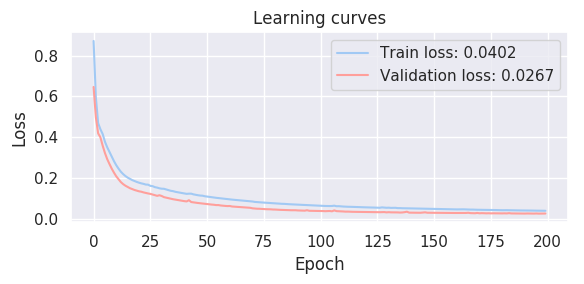

In [0]:
train(train_loader, val_loader, val_df, deep_aec, 200, optimizer, criterion, scheduler=scheduler)

In [0]:
deep_aec = load_model('./best_model.tar')

In [0]:
deep_aec.threshold

tensor(0.1584, device='cuda:0', grad_fn=<AddBackward0>)

Тестируем обученную модель

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score
import time

In [0]:
def fpr(y_true, y_pred):
    conf_matr = confusion_matrix(y_true, y_pred)
    return conf_matr[0, 1] / (conf_matr[0, 1] + conf_matr[0, 0])

def evaluate_model(benign_data, model, normalizer):
    
    attack_names = ['gafgyt_udp', 'gafgyt_tcp', 'gafgyt_scan', 'gafgyt_junk', 
           'gafgyt_combo', 'mirai_udpplain', 'mirai_udp', 'mirai_syn',
           'mirai_scan', 'mirai_ack']
    metrics = {'tpr': recall_score, 'fpr': fpr, 'precision': precision_score,
               'f1_score': f1_score
              }
    results = {}
    
    for attack_name in attack_names:
        df_attack = datasets[attack_name]
        df_attack = normalizer.transform(df_attack)
        x = np.concatenate((benign_data, df_attack))
        y_true = np.concatenate((np.zeros(len(benign_data)), np.ones(len(df_attack))))
        
        assert len(y_true) == len(benign_data) + len(df_attack)
        
        tic = time.time()
        y_pred = model.predict(x)
        toc = time.time()
        
        if -1 in np.unique(y_pred):
            y_pred[y_pred==1] = 0
            y_pred[y_pred==-1] = 1
            
        for metric, func in metrics.items():
            if metric not in results:
                results[metric] = []
            results[metric].append(func(y_true, y_pred))
        
        if 'time' not in results:
            results['time'] = []
        results['time'].append(toc - tic)
        
    return pd.DataFrame(results, index=attack_names)

In [0]:
deep_aec = deep_aec.to('cpu')
deep_aec.threshold = deep_aec.threshold.detach().cpu()
deep_aec.beta = 1.0
dae_df = evaluate_model(test_df, deep_aec, normalizer)

In [0]:
dae_df.head(10)

,tpr,fpr,precision,f1_score,time
gafgyt_udp,0.999653,0.03241,0.998546,0.999099,0.388070
gafgyt_tcp,0.999921,0.03241,0.998303,0.999111,0.334388
gafgyt_scan,0.999389,0.03241,0.994599,0.996988,0.118159
gafgyt_junk,0.999895,0.03241,0.994744,0.997313,0.115746
gafgyt_combo,0.999945,0.03241,0.997226,0.998583,0.211530
mirai_udpplain,1.000000,0.03241,0.998074,0.999036,0.295155
mirai_udp,1.000000,0.03241,0.999007,0.999503,0.570463
mirai_syn,0.999992,0.03241,0.998800,0.999396,0.479170
mirai_scan,0.999695,0.03241,0.996722,0.998206,0.183241
mirai_ack,1.000000,0.03241,0.998647,0.999323,0.408694


In [0]:
dae_df['model'] = pd.Series(['Autoencoder']*10, dtype=str, index=dae_df.index)
dae_df.head(10)

,tpr,fpr,precision,f1_score,time,model
gafgyt_udp,0.999653,0.03241,0.998546,0.999099,0.388070,Autoencoder
gafgyt_tcp,0.999921,0.03241,0.998303,0.999111,0.334388,Autoencoder
gafgyt_scan,0.999389,0.03241,0.994599,0.996988,0.118159,Autoencoder
gafgyt_junk,0.999895,0.03241,0.994744,0.997313,0.115746,Autoencoder
gafgyt_combo,0.999945,0.03241,0.997226,0.998583,0.211530,Autoencoder
mirai_udpplain,1.000000,0.03241,0.998074,0.999036,0.295155,Autoencoder
mirai_udp,1.000000,0.03241,0.999007,0.999503,0.570463,Autoencoder
mirai_syn,0.999992,0.03241,0.998800,0.999396,0.479170,Autoencoder
mirai_scan,0.999695,0.03241,0.996722,0.998206,0.183241,Autoencoder
mirai_ack,1.000000,0.03241,0.998647,0.999323,0.408694,Autoencoder


#### 2.2 One-class SVM

In [0]:
from sklearn.svm import OneClassSVM

In [0]:
one_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [0]:
one_svm.fit(train_df)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [0]:
osvm_df = evaluate_model(test_df, one_svm, normalizer)

In [0]:
osvm_df.head(10)

,tpr,fpr,precision,f1_score,time
gafgyt_udp,1.000000,0.109466,0.995107,0.997547,69.773895
gafgyt_tcp,1.000000,0.109466,0.994291,0.997137,61.176801
gafgyt_scan,0.999820,0.109466,0.981998,0.990829,19.819312
gafgyt_junk,1.000000,0.109466,0.982468,0.991156,19.636249
gafgyt_combo,0.999982,0.109466,0.990692,0.995315,37.433942
mirai_udpplain,1.000000,0.109466,0.993524,0.996752,48.203147
mirai_udp,1.000000,0.109466,0.996653,0.998324,92.458312
mirai_syn,1.000000,0.109466,0.995960,0.997976,78.022686
mirai_scan,1.000000,0.109466,0.989018,0.994479,32.282636
mirai_ack,1.000000,0.109466,0.995446,0.997718,70.618639


In [0]:
osvm_df['model'] = pd.Series(['OC-SVM']*10, dtype=str, index=osvm_df.index)
osvm_df.head(10)

,tpr,fpr,precision,f1_score,time,model
gafgyt_udp,1.000000,0.109466,0.995107,0.997547,69.773895,OC-SVM
gafgyt_tcp,1.000000,0.109466,0.994291,0.997137,61.176801,OC-SVM
gafgyt_scan,0.999820,0.109466,0.981998,0.990829,19.819312,OC-SVM
gafgyt_junk,1.000000,0.109466,0.982468,0.991156,19.636249,OC-SVM
gafgyt_combo,0.999982,0.109466,0.990692,0.995315,37.433942,OC-SVM
mirai_udpplain,1.000000,0.109466,0.993524,0.996752,48.203147,OC-SVM
mirai_udp,1.000000,0.109466,0.996653,0.998324,92.458312,OC-SVM
mirai_syn,1.000000,0.109466,0.995960,0.997976,78.022686,OC-SVM
mirai_scan,1.000000,0.109466,0.989018,0.994479,32.282636,OC-SVM
mirai_ack,1.000000,0.109466,0.995446,0.997718,70.618639,OC-SVM


#### 2.3 LOF

In [0]:
from sklearn.neighbors import LocalOutlierFactor

In [0]:
lof = LocalOutlierFactor(novelty=True, n_jobs=-1)

In [0]:
lof.fit(train_df)

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=-1,
                   n_neighbors=20, novelty=True, p=2)

In [0]:
lof_df = evaluate_model(test_df, lof, normalizer)
lof_df.head(10)

,tpr,fpr,precision,f1_score,time
gafgyt_udp,0.000983,0.104958,0.172589,0.001956,71.416533
gafgyt_tcp,0.000968,0.104958,0.149565,0.001924,62.176886
gafgyt_scan,0.999353,0.104958,0.982718,0.990966,38.598474
gafgyt_junk,0.999755,0.104958,0.983173,0.991395,18.270626
gafgyt_combo,0.999926,0.104958,0.991071,0.995479,22.792559
mirai_udpplain,0.999987,0.104958,0.993789,0.996879,41.452239
mirai_udp,0.999941,0.104958,0.996790,0.998363,60.627227
mirai_syn,0.999960,0.104958,0.996125,0.998039,42.282323
mirai_scan,0.999042,0.104958,0.989456,0.994226,51.041817
mirai_ack,1.000000,0.104958,0.995633,0.997812,48.292755


In [0]:
lof_df['model'] = pd.Series(['LOF']*10, dtype=str, index=lof_df.index)
lof_df.head(10)

,tpr,fpr,precision,f1_score,time,model
gafgyt_udp,0.000983,0.104958,0.172589,0.001956,71.416533,LOF
gafgyt_tcp,0.000968,0.104958,0.149565,0.001924,62.176886,LOF
gafgyt_scan,0.999353,0.104958,0.982718,0.990966,38.598474,LOF
gafgyt_junk,0.999755,0.104958,0.983173,0.991395,18.270626,LOF
gafgyt_combo,0.999926,0.104958,0.991071,0.995479,22.792559,LOF
mirai_udpplain,0.999987,0.104958,0.993789,0.996879,41.452239,LOF
mirai_udp,0.999941,0.104958,0.996790,0.998363,60.627227,LOF
mirai_syn,0.999960,0.104958,0.996125,0.998039,42.282323,LOF
mirai_scan,0.999042,0.104958,0.989456,0.994226,51.041817,LOF
mirai_ack,1.000000,0.104958,0.995633,0.997812,48.292755,LOF


#### 2.4 Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

In [0]:
iso_forest = IsolationForest(n_jobs=-1)

In [0]:
iso_forest.fit(train_df)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=-1, random_state=None, verbose=0, warm_start=False)

In [0]:
if_df = evaluate_model(test_df, iso_forest, normalizer)
if_df.head(10)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.

,tpr,fpr,precision,f1_score,time
gafgyt_udp,0.999499,0.103456,0.995372,0.997431,9.146288
gafgyt_tcp,0.999640,0.103456,0.994600,0.997114,8.290274
gafgyt_scan,0.999641,0.103456,0.982966,0.991233,2.099085
gafgyt_junk,0.999965,0.103456,0.983414,0.991620,2.161964
gafgyt_combo,0.999982,0.103456,0.991199,0.995571,4.322538
mirai_udpplain,1.000000,0.103456,0.993877,0.996929,6.357152
mirai_udp,1.000000,0.103456,0.996836,0.998416,12.768809
mirai_syn,1.000000,0.103456,0.996181,0.998087,11.109628
mirai_scan,0.999978,0.103456,0.989615,0.994769,3.852470
mirai_ack,1.000000,0.103456,0.995695,0.997843,9.510426


In [0]:
if_df['model'] = pd.Series(['IF']*10, dtype=str, index=if_df.index)
if_df.head(10)

,tpr,fpr,precision,f1_score,time,model
gafgyt_udp,0.999499,0.103456,0.995372,0.997431,9.146288,IF
gafgyt_tcp,0.999640,0.103456,0.994600,0.997114,8.290274,IF
gafgyt_scan,0.999641,0.103456,0.982966,0.991233,2.099085,IF
gafgyt_junk,0.999965,0.103456,0.983414,0.991620,2.161964,IF
gafgyt_combo,0.999982,0.103456,0.991199,0.995571,4.322538,IF
mirai_udpplain,1.000000,0.103456,0.993877,0.996929,6.357152,IF
mirai_udp,1.000000,0.103456,0.996836,0.998416,12.768809,IF
mirai_syn,1.000000,0.103456,0.996181,0.998087,11.109628,IF
mirai_scan,0.999978,0.103456,0.989615,0.994769,3.852470,IF
mirai_ack,1.000000,0.103456,0.995695,0.997843,9.510426,IF


Визуализация результатов

In [0]:
common_df = pd.concat((dae_df, osvm_df, lof_df, if_df))
len(common_df)

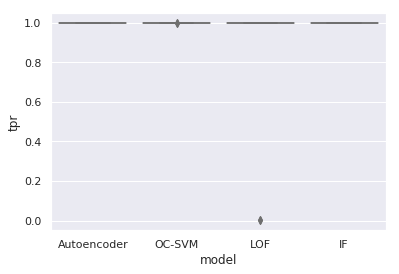

In [0]:
sns.boxplot(x="model", y="tpr", data=common_df)

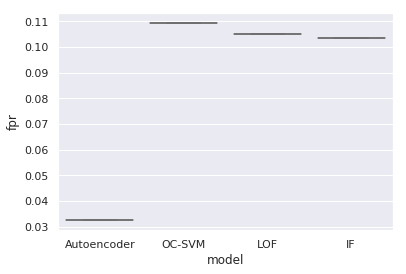

In [0]:
sns.boxplot(x="model", y="fpr", data=common_df);

In [0]:
agg_df = common_df.groupby('model').apply(np.mean)
agg_df['model'] = agg_df.index
agg_df.head()

,tpr,fpr,precision,f1_score,time,model
model,,,,,,
Autoencoder,0.999849,0.032410,0.997467,0.998656,0.310462,Autoencoder
IF,0.999870,0.103456,0.991976,0.995901,6.961863,IF
LOF,0.799992,0.104958,0.825091,0.796704,45.695144,LOF
OC-SVM,0.999980,0.109466,0.991516,0.995723,52.942562,OC-SVM


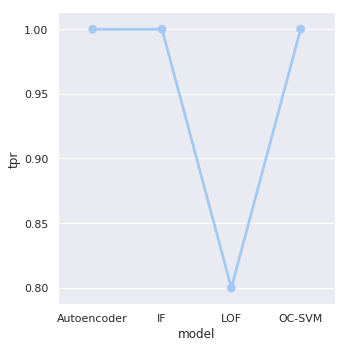

In [0]:
sns.catplot(x="model", y="tpr", data=agg_df, kind="point")

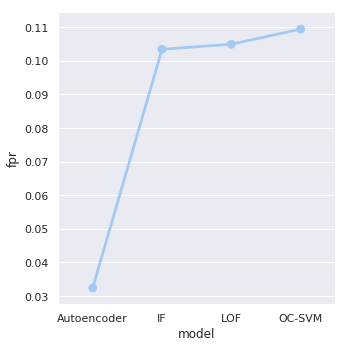

In [0]:
sns.catplot(x="model", y="fpr", data=agg_df, kind="point")

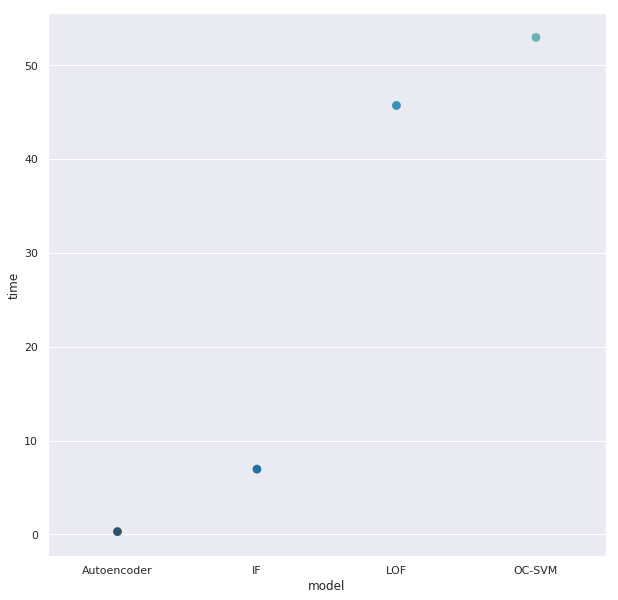

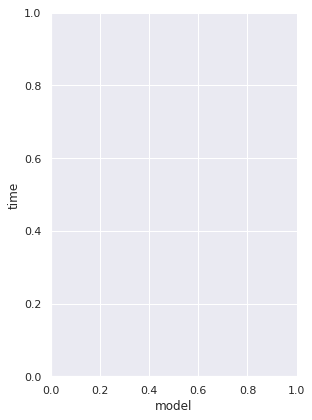

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.catplot(x="model", y="time",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=agg_df, ax=ax)

### 3. Анализ работы автоэнкодера

In [0]:
m = 1000
c = 1
mixed_df = test_df[:m]
y = np.zeros(m)

for _, df in datasets.items():
    if _ == 'benign':
        continue
        
    mixed_df = np.concatenate((mixed_df, normalizer.transform(df)[:m]))
    y = np.concatenate((y, c*np.ones(m)))
    c += 1

assert len(mixed_df) == m*len(datasets) == y.shape[0]
mixed_df = torch.tensor(mixed_df, dtype=torch.float32)

In [0]:
embeddings = deep_aec.enc(mixed_df)
embeddings = embeddings.detach().numpy()

In [0]:
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

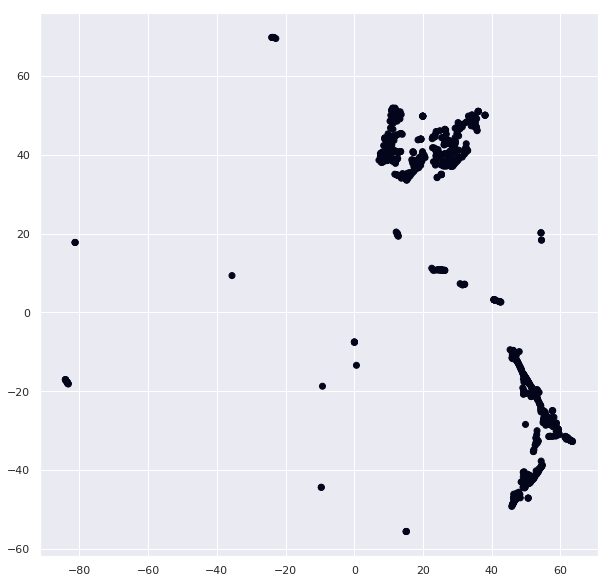

In [0]:
# tSne
embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:1000, 0], embeddings_2d[:1000, 1], c=y[:1000])

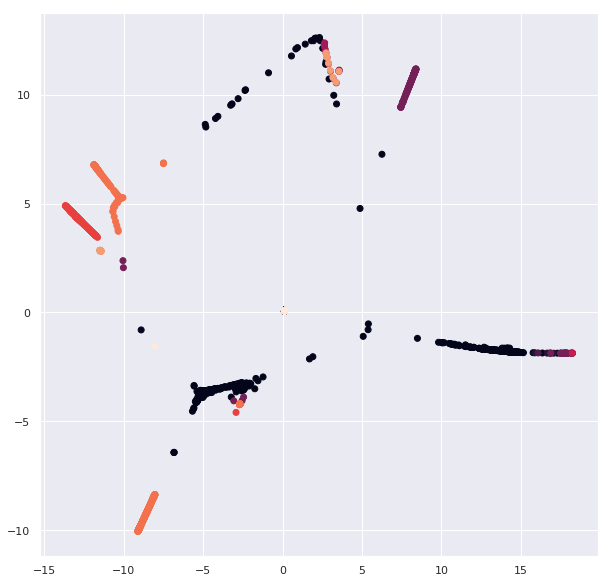

In [0]:
# Isomap
embeddings_2d = Isomap(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y)

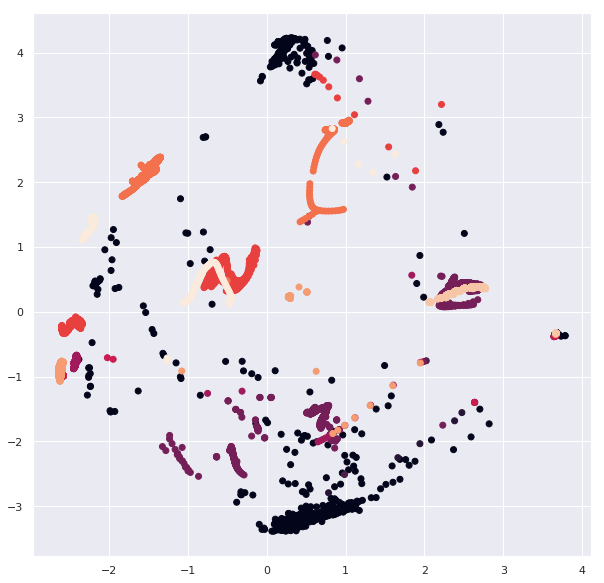

In [0]:
# PCA
embeddings_2d = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y)